# Importation and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import time 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.pipeline import make_pipeline


#############################
import urllib

In [2]:
kaggle=pd.read_csv('/content/kaggle_both.csv') #https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls

In [3]:
phishtank= pd.read_csv('/content/phishtank_fake.csv') #http://data.phishtank.com/data/online-valid.csv

In [4]:
balanced= pd.read_csv('/content/balanced_both.csv') #https://data.mendeley.com/datasets/c2gw7fy2j4/3

In [5]:
phishtank=phishtank[['url','verified']]
phishtank.rename(columns={'url': 'URL','verified':'Label'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
balanced=balanced[['url','status']]
balanced.rename(columns={'url': 'URL','status':'Label'},inplace=True)

In [7]:
phishtank['Label'].replace({'yes':'phishing'},inplace=True)
kaggle['Label'].replace({'good':'legitimate', 'bad':'phishing' },inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [8]:
phishtank.shape

(7324, 2)

In [9]:
 kaggle['Label'].value_counts()

legitimate    392924
phishing      156422
Name: Label, dtype: int64

In [10]:
phishing_sites = kaggle[kaggle.Label == 'phishing']
real_sites = kaggle[kaggle.Label == 'legitimate']
real_sites = real_sites.iloc[:phishing_sites.shape[0]-35000]

In [11]:
kaggle= pd.concat([phishing_sites , real_sites, real_sites.iloc[:phishtank.shape[0]]],ignore_index=True)

In [12]:
 kaggle['Label'].value_counts()

phishing      156422
legitimate    128746
Name: Label, dtype: int64

In [13]:
df= pd.concat([kaggle,phishtank,balanced],ignore_index=True)

In [14]:
df.shape

(303922, 2)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df['Label'].value_counts()

phishing      127197
legitimate    127133
Name: Label, dtype: int64

In [17]:
df.shape

(254330, 2)

In [18]:
df['Label'].value_counts()

phishing      127197
legitimate    127133
Name: Label, dtype: int64

In [19]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

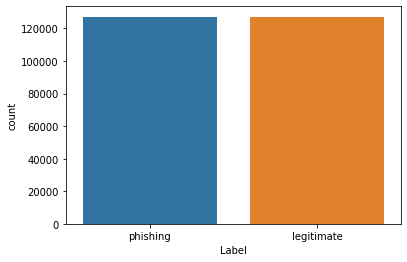

In [20]:
sns.countplot(x="Label",data=df)

NLP

# Feature extraction

In [21]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))


In [22]:
stemmer = SnowballStemmer("english") # choose a language
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])


In [23]:
# Joining all the stemmmed words.
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))


In [24]:
df['URL_length']=df['URL'].map(lambda l: len(l))

In [25]:
!pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import tldextract

In [27]:
def get_component(url):
    o = urllib.parse.urlsplit(url)
    return o.hostname, tldextract.extract(url).domain, o.path


In [28]:
df['domain']= df['URL'].map(lambda l: get_component(l)[1])

In [29]:
df['domain']

0                         nobell
1                        dghjdgf
2                   serviciosbys
3                      printakid
4                thewhiskeydregs
                   ...          
303917                 fontspace
303918                budgetbots
303919                  facebook
303920    mypublicdomainpictures
303921            174.139.46.123
Name: domain, Length: 254330, dtype: object

In [30]:
import re #regular expression library

In [31]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)|'  # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '[0-9a-fA-F]{7}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [32]:
df['has_ip']= df['URL'].map(lambda l: having_ip_address(l))

In [33]:
############################################
df.loc[11427]['URL']

'ppweb.httpxxcwwwhttps.igg.biz/65801783/65801783'

In [34]:
!pip install parse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from urllib.parse import urlparse

In [36]:
def https_token(url):
  a = urlparse(url)
  if a.scheme == 'https':
      return 1
  return 0

In [37]:
df['scheme_https']= df['URL'].map(lambda l: https_token(l))

In [38]:
def n_digits(domain):
    return len(re.sub("[^0-9]", "", domain)) ####

In [39]:
df.iloc[11429]

URL               multiflashonline.com/live/redirection/redirect...
Label                                                      phishing
text_tokenized    [multiflashonline, com, live, redirection, red...
text_stemmed      [multiflashonlin, com, live, redirect, redirec...
text_sent            multiflashonlin com live redirect redirect php
URL_length                                                       53
domain                                             multiflashonline
has_ip                                                            0
scheme_https                                                      0
Name: 11429, dtype: object

In [40]:
# def ratio_digits(domain):
    #return len(re.sub("[^0-9]", "", domain))/len(domain)

In [41]:
# df['digit_letter_ratio']= df['domain'].map(lambda l:  ratio_digits(l))

In [42]:
df.tail(5)

,URL,Label,text_tokenized,text_stemmed,text_sent,URL_length,domain,has_ip,scheme_https
303917,http://www.fontspace.com/category/blackletter,legitimate,"[http, www, fontspace, com, category, blacklet...","[http, www, fontspac, com, categori, blacklett]",http www fontspac com categori blacklett,45,fontspace,0,0
303918,http://www.budgetbots.com/server.php/Server%20...,phishing,"[http, www, budgetbots, com, server, php, Serv...","[http, www, budgetbot, com, server, php, serve...",http www budgetbot com server php server updat...,84,budgetbots,0,0
303919,https://www.facebook.com/Interactive-Televisio...,legitimate,"[https, www, facebook, com, Interactive, Telev...","[https, www, facebook, com, interact, televis,...",https www facebook com interact televis pvt lt...,105,facebook,1,1
303920,http://www.mypublicdomainpictures.com/,legitimate,"[http, www, mypublicdomainpictures, com]","[http, www, mypublicdomainpictur, com]",http www mypublicdomainpictur com,38,mypublicdomainpictures,0,0
303921,http://174.139.46.123/ap/signin?openid.pape.ma...,phishing,"[http, ap, signin, openid, pape, max, auth, ag...","[http, ap, signin, openid, pape, max, auth, ag...",http ap signin openid pape max auth age amp op...,477,174.139.46.123,1,0


In [43]:
df['text_sent']

0         nobel it ffb d dca cce f login skype com en cg...
1         www dghjdgf com paypal co uk cycgi bin webscrc...
2         serviciosbi com paypal cgi bin get into herf s...
3         mail printakid com www onlin americanexpress c...
4         thewhiskeydreg com wp content theme widescreen...
                                ...                        
303917             http www fontspac com categori blacklett
303918    http www budgetbot com server php server updat...
303919    https www facebook com interact televis pvt lt...
303920                    http www mypublicdomainpictur com
303921    http ap signin openid pape max auth age amp op...
Name: text_sent, Length: 254330, dtype: object

In [44]:
cv = CountVectorizer()
feature = cv.fit_transform(df.text_sent) #transform all text which we tokenize and stemed

In [45]:
df.columns

Index(['URL', 'Label', 'text_tokenized', 'text_stemmed', 'text_sent',
       'URL_length', 'domain', 'has_ip', 'scheme_https'],
      dtype='object')

In [46]:
# import pandas as pd
# df = pd.get_dummies(df1, columns=['URL', 'Label', 'text_tokenized', 'text_stemmed', 'text_sent'])

In [47]:
from sklearn.model_selection import train_test_split
x1=df['URL']
X_train, X_test, y_train, y_test  = train_test_split(feature,df.Label, test_size=0.24)#25=84.80,24=85.14
# X_train, X_test, y_train, y_test = train_test_split(x1,df1.Label, random_state=42, shuffle=True, train_size=0.6)

In [48]:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from collections import Counter

# # fit model no training data
# model= XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=5000,
#  max_depth=4,
#  min_child_weight=6,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  reg_alpha=0.005,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# model.fit(X_train, y_train)
# print(model)


# # make predictions for test data
# y_pred = model.predict(X_test)
# #predictions=Counter([type(value) for value in y_pred])

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print('confusion matrix:\n',confusion_matrix(y_test,y_pred))
# print("report:",classification_report(y_test,y_pred))


In [49]:
df

,URL,Label,text_tokenized,text_stemmed,text_sent,URL_length,domain,has_ip,scheme_https
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,phishing,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...,225,nobell,1,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,phishing,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...,81,dghjdgf,0,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,phishing,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...,177,serviciosbys,1,0
3,mail.printakid.com/www.online.americanexpress....,phishing,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...,60,printakid,0,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,phishing,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...,116,thewhiskeydregs,1,0
...,...,...,...,...,...,...,...,...,...
303917,http://www.fontspace.com/category/blackletter,legitimate,"[http, www, fontspace, com, category, blacklet...","[http, www, fontspac, com, categori, blacklett]",http www fontspac com categori blacklett,45,fontspace,0,0
303918,http://www.budgetbots.com/server.php/Server%20...,phishing,"[http, www, budgetbots, com, server, php, Serv...","[http, www, budgetbot, com, server, php, serve...",http www budgetbot com server php server updat...,84,budgetbots,0,0
303919,https://www.facebook.com/Interactive-Televisio...,legitimate,"[https, www, facebook, com, Interactive, Telev...","[https, www, facebook, com, interact, televis,...",https www facebook com interact televis pvt lt...,105,facebook,1,1
303920,http://www.mypublicdomainpictures.com/,legitimate,"[http, www, mypublicdomainpictures, com]","[http, www, mypublicdomainpictur, com]",http www mypublicdomainpictur com,38,mypublicdomainpictures,0,0


# Modeling [Decision Trees]

RandomizedSearch for hyperparameter tuning

In [57]:
# from scipy.stats import randint
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import accuracy_score

# # Setup the parameters and distributions to sample from: param_dist
# param_dist = {"max_depth": randint(1, 20),
#               "max_features": randint(1, 9),
#               "min_samples_leaf": randint(1, 9),
#               "criterion": ["gini", "entropy"]}

# # Instantiate a Decision Tree classifier: tree
# tree = DecisionTreeClassifier(random_state=42)

# # Instantiate the RandomizedSearchCV object: tree_cv
# tree_cv = RandomizedSearchCV(tree, param_dist, cv=40)


# # Fit it to the data
# tree_cv.fit(X_train, y_train)


# ################################
# y_pred1 = tree_cv.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred1)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print('confusion matrix:\n',confusion_matrix(y_test,y_pred1))
# print("report:",classification_report(y_test,y_pred1))
# ###############################
# # Print the tuned parameters and score
# print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
# print("Best score is {}".format(tree_cv.best_score_))

NotFittedError: ignored

<Figure size 5760x1440 with 0 Axes>

Grid search for hyperparameters tuning


In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('confusion matrix:\n',confusion_matrix(y_test,y_pred1))
print("report:",classification_report(y_test,y_pred1))

In [ ]:
# from sklearn import decomposition, datasets
# from sklearn import tree
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# std_slc = StandardScaler()
# pca = decomposition.PCA()
# dec_tree = tree.DecisionTreeClassifier()
# pipe = Pipeline(steps=[('std_slc', std_slc),
#                            ('pca', pca),
#                            ('dec_tree', dec_tree)])
# n_components = list(range(1,X_train.shape[1]+1,1))
# criterion = ['gini', 'entropy']
# max_depth = [2,4,6,8,10,12]
# parameters = dict(pca__n_components=n_components,
#                       dec_tree__criterion=criterion,
#                       dec_tree__max_depth=max_depth)
# clf_GS = GridSearchCV(pipe, parameters)
# clf_GS.fit(X_train, y_train)
# print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
# print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
# print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
# print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])